# Pima Indians Diabetes Database

The objective of this notebook is to build a model that diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

Importing necessary libraries..

In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score

from pprint import pprint

Loading the data

In [3]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## EDA and Preprocessing

In [4]:
data.shape

(768, 9)

In [5]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

There are 768 points in the dataset. Taking the first 700 of them for training and remaining 68 for testing

In [6]:
train_data = data.iloc[:700, :]
test_data = data.iloc[700:, :]

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               700 non-null    int64  
 1   Glucose                   700 non-null    int64  
 2   BloodPressure             700 non-null    int64  
 3   SkinThickness             700 non-null    int64  
 4   Insulin                   700 non-null    int64  
 5   BMI                       700 non-null    float64
 6   DiabetesPedigreeFunction  700 non-null    float64
 7   Age                       700 non-null    int64  
 8   Outcome                   700 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 49.3 KB


There are no null/np.Nan values in the dataset.

In [8]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,700.0,3.827143,3.364394,0.000,1.00,3.0000,6.000,17.00
Glucose,700.0,120.541429,32.208854,0.000,99.00,116.5000,140.250,199.00
BloodPressure,700.0,68.880000,19.540718,0.000,63.50,72.0000,80.000,122.00
SkinThickness,700.0,20.382857,16.032219,0.000,0.00,23.0000,32.000,99.00
Insulin,700.0,79.880000,115.590119,0.000,0.00,36.5000,126.500,846.00
BMI,700.0,31.891286,7.949977,0.000,27.00,32.0000,36.500,67.10
DiabetesPedigreeFunction,700.0,0.476019,0.337357,0.078,0.24,0.3755,0.637,2.42
Age,700.0,33.124286,11.784558,21.000,24.00,29.0000,40.000,81.00
Outcome,700.0,0.344286,0.475475,0.000,0.00,0.0000,1.000,1.00


All the features are numeric.

Pregnancies and Age are discrete numeric features, while the remaining features are continuous.

Features Glucose, BloodPressure, SkinThickness, Insulin and BMI has 0 values, which doesn't make sense.

We will substitute the 0 values with median of the feature, with respect to whether the target value is 0 (non-diabetic) or 1 (diabetic).

In [9]:
pd.options.mode.chained_assignment = None  # default='warn'
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI',]:
  pos_cls_avg = train_data[col][train_data['Outcome'] == 1].median()
  neg_cls_avg = train_data[col][train_data['Outcome'] == 0].median()

  train_data.loc[(train_data[col]==0) & (train_data['Outcome'] == 1), col] = pos_cls_avg
  train_data.loc[(train_data[col]==0) & (train_data['Outcome'] == 0), col] = neg_cls_avg

In [10]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,700.0,3.827143,3.364394,0.000,1.000,3.0000,6.000,17.00
Glucose,700.0,121.400000,30.571336,44.000,99.000,117.0000,140.250,199.00
BloodPressure,700.0,72.265714,12.123033,24.000,64.000,72.0000,80.000,122.00
SkinThickness,700.0,27.134286,9.595643,7.000,20.000,27.0000,32.000,99.00
Insulin,700.0,92.280000,108.258705,0.000,40.000,40.0000,126.500,846.00
BMI,700.0,32.324571,6.965823,18.200,27.375,32.0000,36.500,67.10
DiabetesPedigreeFunction,700.0,0.476019,0.337357,0.078,0.240,0.3755,0.637,2.42
Age,700.0,33.124286,11.784558,21.000,24.000,29.0000,40.000,81.00
Outcome,700.0,0.344286,0.475475,0.000,0.000,0.0000,1.000,1.00


Plotting histograms of the features to get an idea of the distribution

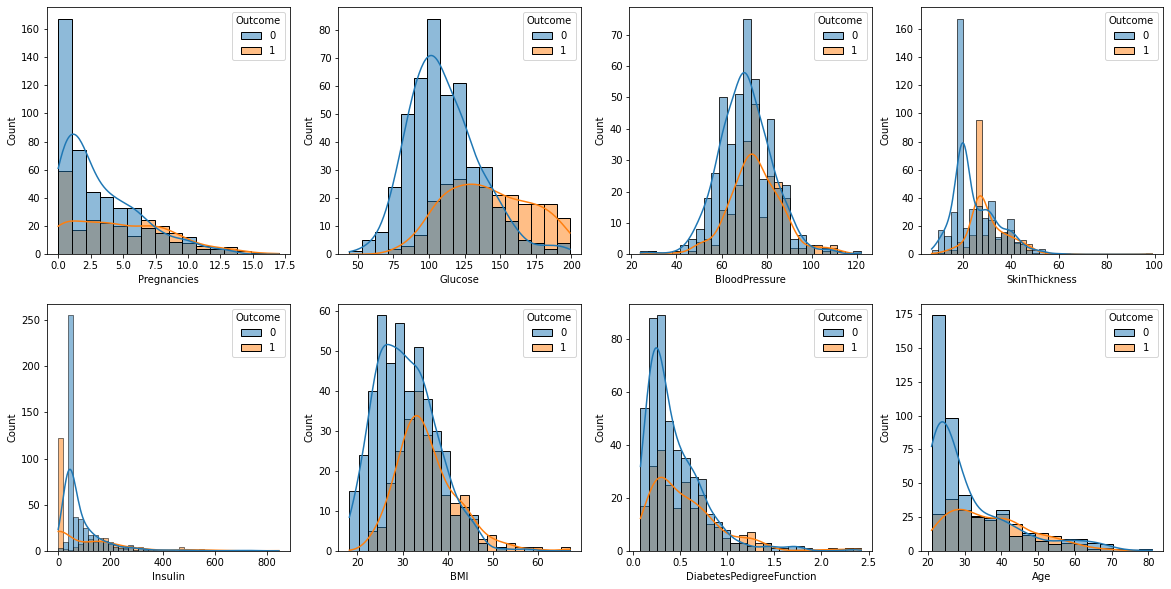

In [11]:
fig, ax = plt.subplots(2,4, figsize=(20,10))

c=0
for i in range(2):
  for j in range(4):
    sns.histplot(train_data, x=train_data.iloc[:,c], hue='Outcome', 
                 ax=ax[i][j], kde=True)
    c+=1
    

Features Pregnancies, Insulin, DiabetesPedigree Function are tail heavy while all others follow almost a normal distribution

Plotting boxplots to check for outliers

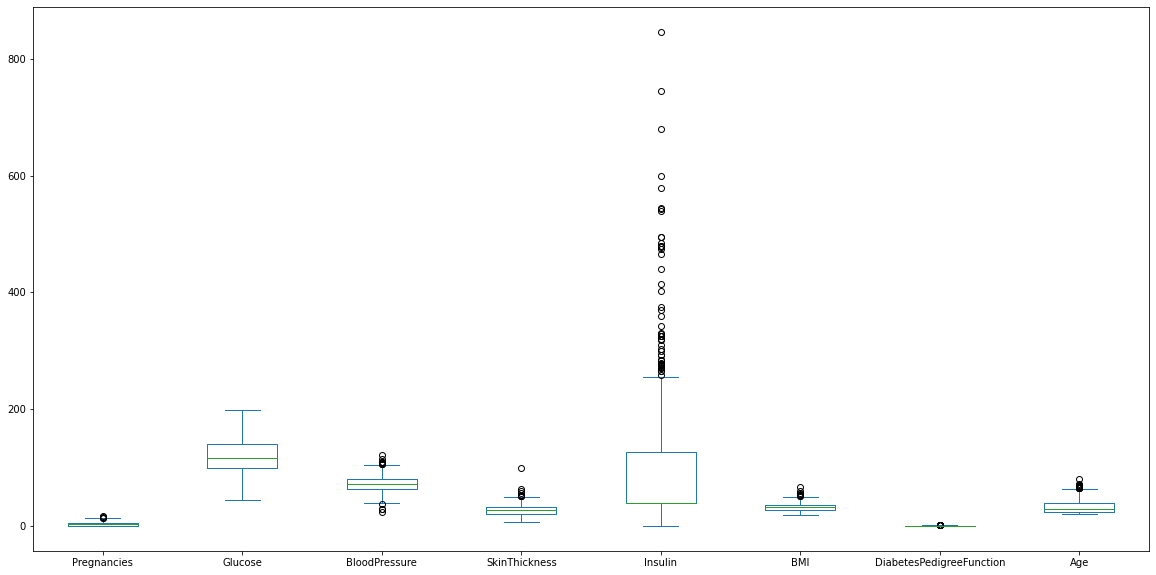

In [12]:
train_data.iloc[:,:-1].plot.box(figsize=(20,10))

Except for Glucose, all other features have outliers in them.

Outliers can affect the model performance. Hence, we will use statistical methods to deal with them. 

We can use the Lower and Upper bound values (which we use to detect outliers) calculated from 5 Point Summary and Inter Quartile Range. 

In [13]:
for col in train_data.columns[:-1]:
  quartiles = np.quantile(train_data[col], [0.25, 0.75])
  iqr = quartiles[1] - quartiles[0]
  u = quartiles[1] + 1.5*iqr
  l = quartiles[0] - 1.5*iqr

  train_data[col] = np.where(train_data[col] > u, u, train_data[col])
  train_data[col] = np.where(train_data[col] < l, l, train_data[col])

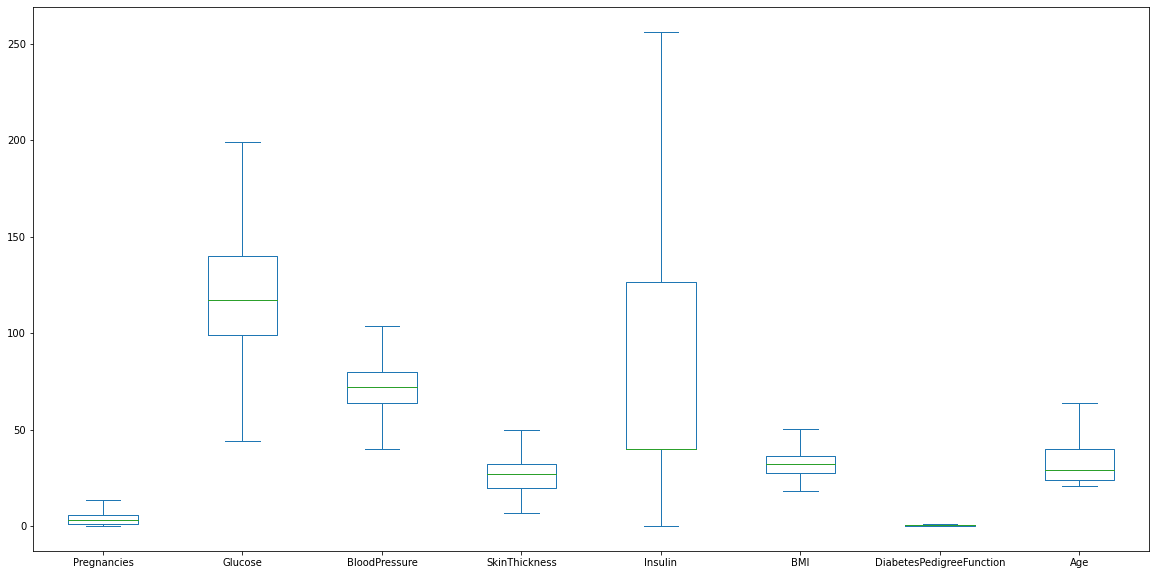

In [14]:
train_data.iloc[:,:-1].plot.box(figsize=(20,10))

All outliers are removed.

Plotting histograms again for the distributions

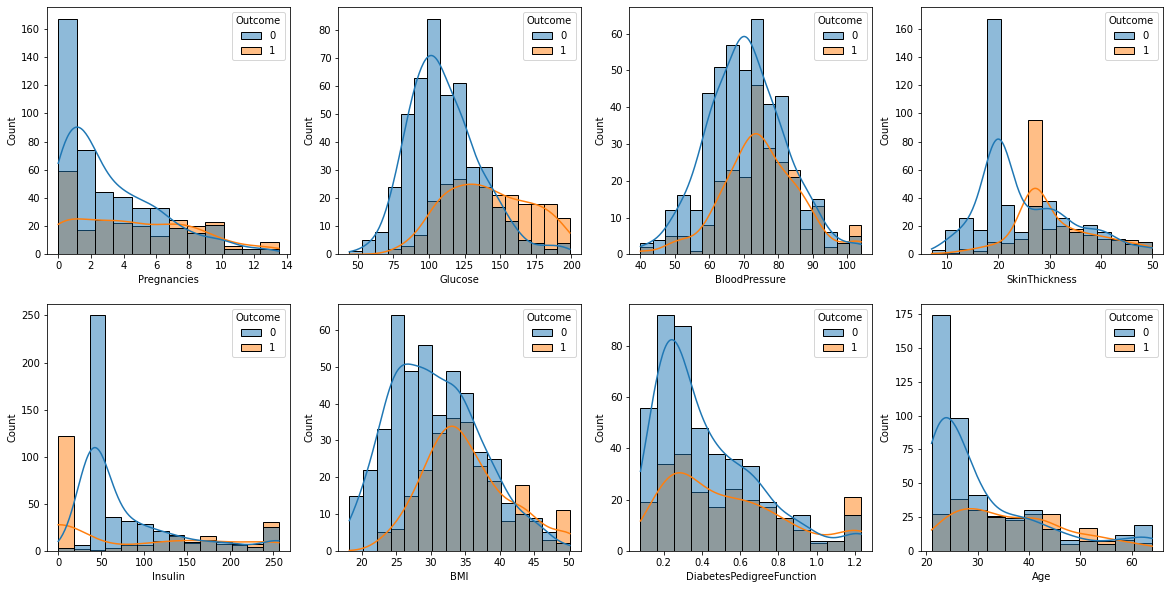

In [15]:
fig, ax = plt.subplots(2,4, figsize=(20,10))

c=0
for i in range(2):
  for j in range(4):
    sns.histplot(train_data, x=train_data.iloc[:,c], hue='Outcome', 
                 ax=ax[i][j], kde=True)
    c+=1

Since the outliers were replaced, the distributions became more concentrated and can be fit inside a smaller numerical range in X-axis.

Now, splitting into input features and target value and plotting a heatmap...

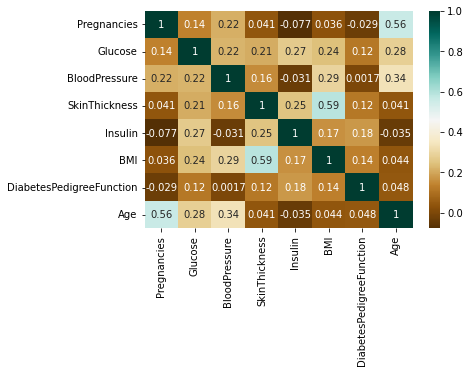

In [16]:
X_train = train_data.iloc[:,:-1]
y_train = train_data.iloc[:,-1]

sns.heatmap(X_train.corr(), cmap='BrBG', annot=True)

Number of Pregnancies and Age has high correlation among them, which is expected and makes sense.

BMI and SkinThickness also has high correlation among them.

Performing the same preprocessing steps to testing data..

In [17]:
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI',]:
  pos_cls_avg = train_data[col][train_data['Outcome'] == 1].median()
  neg_cls_avg = train_data[col][train_data['Outcome'] == 0].median()

  test_data.loc[(test_data[col]==0) & (test_data['Outcome'] == 1), col] = pos_cls_avg
  test_data.loc[(test_data[col]==0) & (test_data['Outcome'] == 0), col] = neg_cls_avg

for col in test_data.columns[:-1]:
  quartiles = np.quantile(test_data[col], [0.25, 0.75])
  iqr = quartiles[1] - quartiles[0]
  u = quartiles[1] + 1.5*iqr
  l = quartiles[0] - 1.5*iqr

  test_data[col] = np.where(test_data[col] > u, u, test_data[col])
  test_data[col] = np.where(test_data[col] < l, l, test_data[col])

X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In the above cell, the 0 values and outliers are replaced with values computed from training set in order to prevent data spoofing.

Plotting a pairplot on training data to get a better idea..

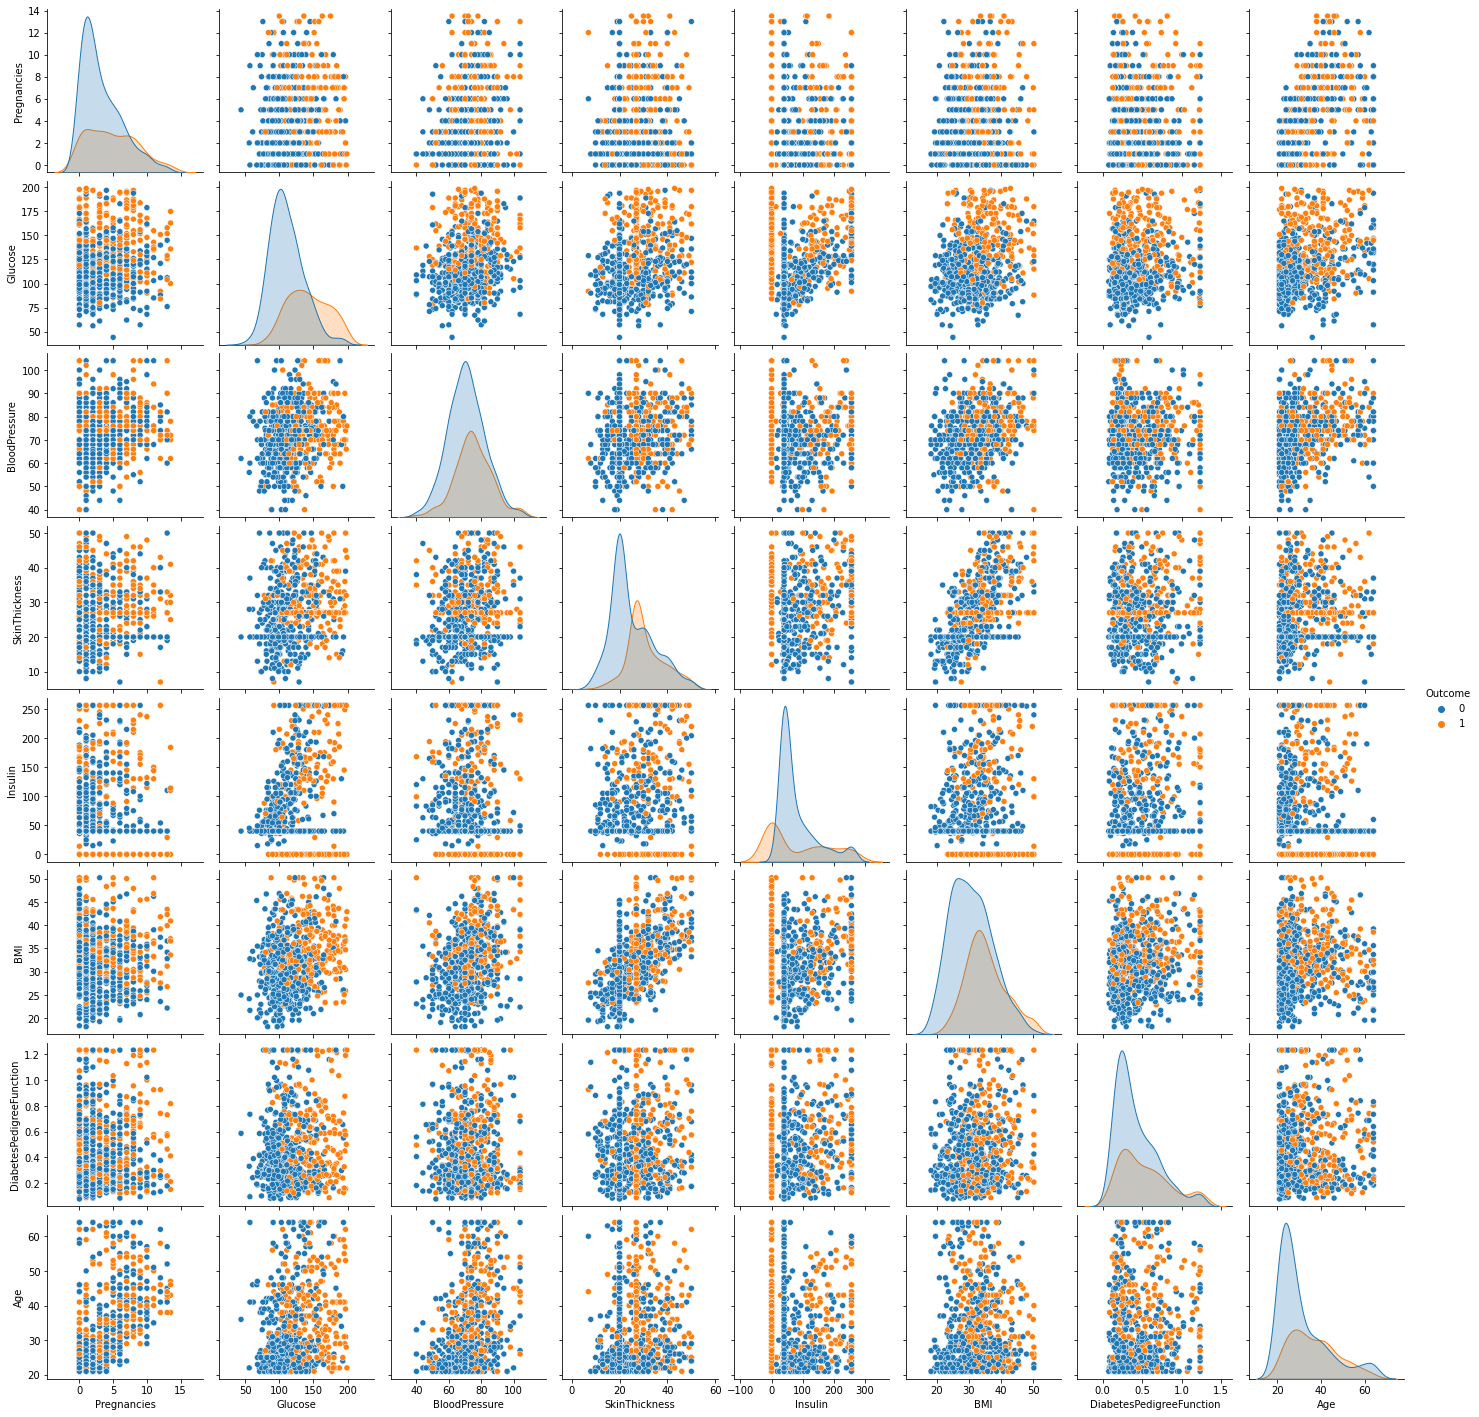

In [18]:
sns.pairplot(train_data, hue='Outcome')

The pairplot shows that the data has non-linear separation and there is a lot of overlapping between the points with different outcomes. So possible models are:
1. Linear models with Polynomial transformation
2. Knn
3. DecisionTree
4. RandomForests

Lets build KNN Classifier and Random Forests Classifier models

## KNN Classifier

In [19]:
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', KNeighborsClassifier())
])

pipe_knn.fit(X_train, y_train)

print('Score of KNN on training set: ', pipe_knn.score(X_train, y_train))
print('Score of KNN on testing set: ', pipe_knn.score(X_test, y_test))

Score of KNN on training set:  0.88
Score of KNN on testing set:  0.8529411764705882


Classification Report and Confusion Matrix..

In [20]:
y_hat = pipe_knn.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        41
           1       0.84      0.78      0.81        27

    accuracy                           0.85        68
   macro avg       0.85      0.84      0.84        68
weighted avg       0.85      0.85      0.85        68



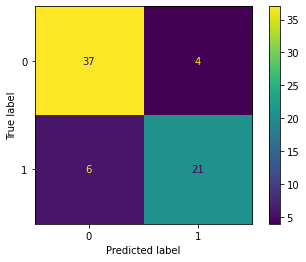

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)

# RandomForestClassifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

rfc_clf = RandomForestClassifier()
rfc_clf.fit(X_train, y_train)

print(rfc_clf.score(X_train, y_train))
print(rfc_clf.score(X_test, y_test))

1.0
0.9264705882352942


Classification Report and Confusion Matrix

In [23]:
y_hat = rfc_clf.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        41
           1       0.92      0.89      0.91        27

    accuracy                           0.93        68
   macro avg       0.93      0.92      0.92        68
weighted avg       0.93      0.93      0.93        68



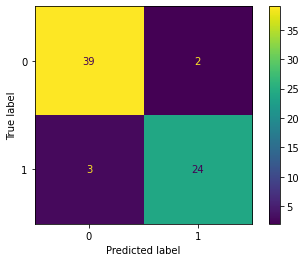

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)

RandomForest Model is performing better than KNN Model

## AUC-ROC Curve

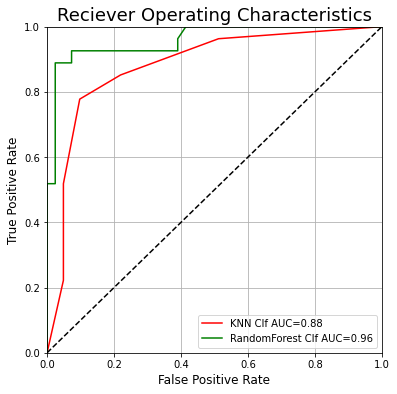

In [76]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

knn_scores = pipe_knn.predict_proba(X_test)
rfc_scores = rfc_clf.predict_proba(X_test)

knn_fpr, knn_tpr, knn_thresh = roc_curve(y_test,knn_scores[:,1])
rfc_fpr, rfc_tpr, rfc_thresh = roc_curve(y_test, rfc_scores[:,1])

knn_auc = auc(knn_fpr, knn_tpr)
rfc_auc = auc(rfc_fpr, rfc_tpr)

plt.figure(figsize=(6,6))
plt.plot(knn_fpr, knn_tpr, color='r', label='KNN Clf AUC=%0.2f'%knn_auc)
plt.plot(rfc_fpr, rfc_tpr, color='green', label='RandomForest Clf AUC=%0.2f'%rfc_auc)
plt.plot([0,1], [0,1], color='black', linestyle='dashed')

plt.title('Reciever Operating Characteristics', fontsize=18)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()